In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from scipy import stats
from scipy.stats import linregress
import seaborn as sns


# Read in Spotify data csv
spotify_data = pd.read_csv("Resources/data.csv")

spot_data = pd.DataFrame(spotify_data)

spot_data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [2]:
# Clean and format data
spot_data.columns

drop_columns = ['acousticness', 'duration_ms', 'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'speechiness', 'tempo',
       'valence']
clean_spot = spot_data.drop(columns=drop_columns)

clean_spot = clean_spot.rename(columns={"artists":"Artist","danceability":"Danceability (%)","explicit":"Explicit",
                                        "name":"Song Name","popularity":"Popularity","release_date":"Release Date",
                                        "year":"Release Year"})

clean_spot["Danceability (%)"] = clean_spot["Danceability (%)"]*100

clean_spot["Artist"] = clean_spot["Artist"].str.strip('[]')
clean_spot["Artist"] = clean_spot["Artist"].str.strip('[""]')
clean_spot["Artist"] = clean_spot["Artist"].str.strip("['']")

clean_spot.head()

,Artist,Danceability (%),Explicit,Song Name,Popularity,Release Date,Release Year
0,Mamie Smith,59.8,0,Keep A Song In Your Soul,12,1920,1920
1,Screamin' Jay Hawkins,85.2,0,I Put A Spell On You,7,1920-01-05,1920
2,Mamie Smith,64.7,0,Golfing Papa,4,1920,1920
3,Oscar Velazquez,73.0,0,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,1920
4,Mixe,70.4,1,Xuniverxe,2,1920-10-01,1920


In [19]:
# How many artist contributed to this database?

unique_artists = clean_spot["Artist"].nunique()
total_artists = clean_spot["Artist"].count()
art_percentage = unique_artists/total_artists
art_percentage = art_percentage * 100
art_percentage = round(art_percentage, 2)
print(f"There are {total_artists} Tracks in this database, and {unique_artists} unique artists in the DB. {art_percentage}% of Artists made the majority of the songs in this Database")


There are 174389 Tracks in this database, and 36194 unique artists in the DB. 20.75% of Artists made the majority of the songs in this Database


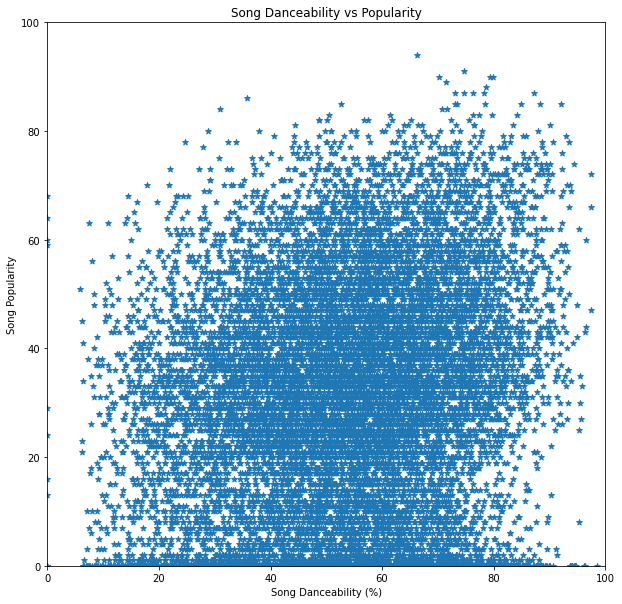

There seems to be no relation between danceability & Popularity given the equal distribution of of populatity among Danceability axis. In fact, on the very high end of dancability, it seems as though populatity declines making the hypothisis null.


In [20]:
# Pull sample of data and create scatter plot

samp_spot = clean_spot.sample(frac=0.1, replace=False, random_state=1)

plt.figure(figsize=(10,10))
plt.title("Song Danceability vs Popularity")
plt.scatter(samp_spot["Danceability (%)"],samp_spot["Popularity"], marker="*")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Song Danceability (%)")
plt.ylabel("Song Popularity")
plt.savefig("Images/PopvsDance.png")
plt.show()


print("There seems to be no relation between danceability & Popularity given the equal distribution of of populatity among Danceability axis. In fact, on the very high end of dancability, it seems as though populatity declines making the hypothisis null.")

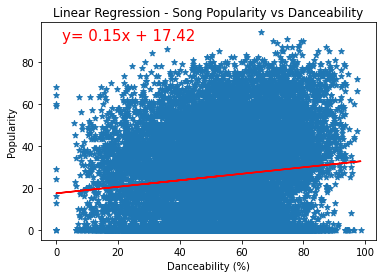

The r-value is: 0.015329083739064523


In [21]:
# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(samp_spot["Danceability (%)"],samp_spot["Popularity"])
regress = samp_spot["Danceability (%)"] * slope + intercept
lin_eq = "y= " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.scatter(samp_spot["Danceability (%)"],samp_spot["Popularity"], marker="*")
plt.plot(samp_spot["Danceability (%)"], regress, "r-")
plt.annotate(lin_eq, (2, 90), fontsize=15, color="red")
plt.ylabel("Popularity")
plt.xlabel("Danceability (%)")
plt.title("Linear Regression - Song Popularity vs Danceability")
plt.savefig("Images/LinRegress.png")
plt.show()

print(f"The r-value is: {rvalue**2}")


In [31]:
# Find song count per artist
groupie = clean_spot.groupby('Artist').count()

groupie = groupie.sort_values('Danceability (%)', ascending=False)
groupie = groupie.drop(columns=["Danceability (%)","Explicit","Song Name","Popularity","Release Date"])
groupie = groupie.rename(columns={"Release Year":"Song Count"})

groupie = groupie.head(1000)
groupie

,Song Count
Artist,
Tadeusz Dolega Mostowicz,1281
Эрнест Хемингуэй,1175
Эрих Мария Ремарк,1062
Francisco Canaro,951
Ignacio Corsini,624
...,...
Bill Cosby,30
Blaise Kolodychuk and the Fukachuk Egg Machine,30
The Kelly Family,30


In [25]:
# Find most danceable song
clean_spot.sort_values(by='Danceability (%)', ascending=False, inplace=True)
clean_spot.head(20)

,Artist,Danceability (%),Explicit,Song Name,Popularity,Release Date,Release Year
13734,Tone-Loc,98.8,0,Funky Cold Medina,56,1989-01-01,1989
54525,"Spooner Street', 'Rio Dela Duna', 'Leonardo La...",98.7,0,Cool - Leonardo La Mark Remix,0,2021-01-15,2021
141441,"Pitbull', 'Trina', 'Young Bo",98.6,1,Go Girl,52,2012-05-08,2012
92739,Nilla Pizzi,98.5,0,O mama mama - Remix 2014,0,2014-11-27,2014
171536,"Dan McKie', 'Zigmund Slezak",98.5,0,Dddance - Zigmund Slezak Remix,0,2013-01-07,2013
37455,Tone-Loc,98.5,0,Funky Cold Medina - Re-Recorded,7,2010-12-21,2010
173266,Michael Beyer,98.2,0,Stuck in Your Brain,0,2016-07-07,2016
39276,347aidan,98.0,1,Dancing in My Room,84,2020-10-26,2020
51218,"The Jacksons', 'Mick Jagger",98.0,0,State of Shock,43,1984-10-30,1984
13910,Vanilla Ice,98.0,0,Ice Ice Baby,61,1990-01-01,1990


In [26]:
# Find most popular artist
artist = clean_spot.groupby("Artist").sum()
artist.sort_values(by='Popularity', ascending=False, inplace=True)
artist.drop(columns=["Explicit","Release Year"],inplace=True)
art = artist.head(100)
art

,Danceability (%),Popularity
Artist,,
The Beatles,21513.59,19110
Frank Sinatra,23558.98,17434
Elvis Presley,24299.30,16998
Fleetwood Mac,26164.10,15927
The Rolling Stones,23705.30,15817
...,...,...
Bob Seger,5868.90,4107
Javier Solís,7888.70,4094
Joni Mitchell,6359.00,4090


In [27]:
# Group by release year and find average danceability/popularity of songs released within each year
grouped_year = clean_spot.groupby(["Release Year"])
grouped_year.dtypes

year_df = pd.DataFrame({"Danceability (%)": grouped_year["Danceability (%)"].mean(),
                       "Popularity": grouped_year["Popularity"].mean()})
year_df

,Danceability (%),Popularity
Release Year,,
1920,51.575014,0.610315
1921,43.217051,0.391026
1922,57.561983,0.090909
1923,57.734054,5.205405
1924,54.989407,0.661017
...,...,...
2017,58.047519,31.662338
2018,60.273091,27.599484
2019,60.310142,32.346930


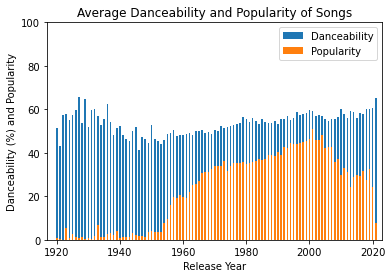

In [12]:
# Create bar chart to show avg danceability/popularity
years = np.arange(1920, 2022, 1)
dance_points = year_df["Danceability (%)"]
pop_points = year_df["Popularity"]

fig, ax = plt.subplots()
ind = years
width = .5
p1 = ax.bar(ind, dance_points, width)
p2 = ax.bar(ind, pop_points, width)
ax.set_title("Danceability and Popularity")
# ax.set_xticks(ind + width / 2)
ax.autoscale_view()
plt.xlim(1917, 2023)
plt.ylim(0, 100)
ax.legend((p1, p2), ("Danceability", "Popularity"))
plt.xlabel("Release Year")
plt.ylabel("Danceability (%) and Popularity")
plt.title("Average Danceability and Popularity of Songs")
plt.savefig("Images/DancePopOverTime.png")
plt.show()

In [13]:
# Count explicit & non explicit songs
grouped_Explicit = clean_spot.groupby(["Explicit"])
grouped_year = clean_spot.groupby(["Release Year"])
grouped_Explicit.dtypes

Explicit_df = pd.DataFrame({"Tracks": grouped_Explicit["Explicit"].count(),})                       
                     
Explicit_df

,Tracks
Explicit,
0,162507
1,11882


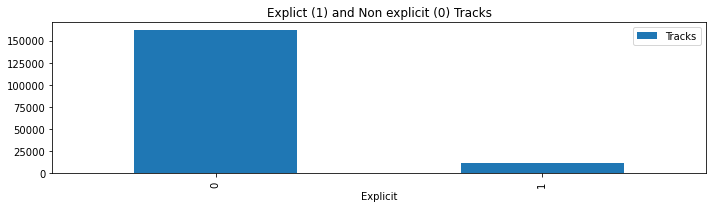

There are far more Non Explict tracts than Explict tracks


In [29]:
Explicit_df.plot(kind="bar", figsize=(10,3))
plt.title("Explict (1) and Non explicit (0) Tracks")
plt.tight_layout()
plt.savefig("Images/ExplictTracks")
plt.show()

print(f"There are far more Non Explict tracts than Explict tracks")

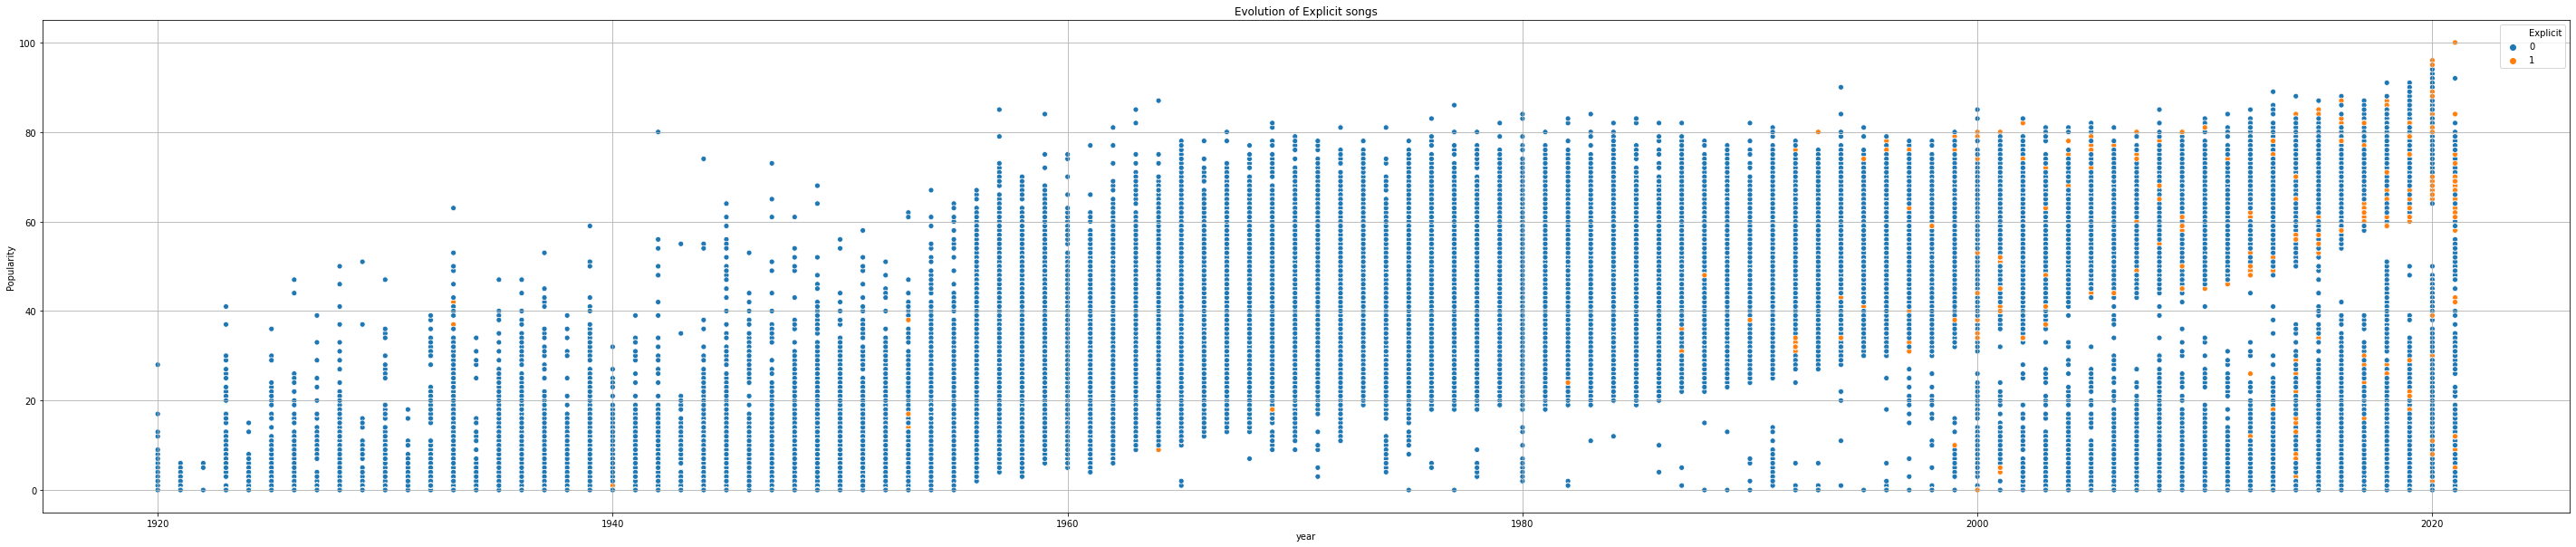

Newer songs are more explicit and popular


In [30]:
# Are songs becoming more explicit?
# Run scatter plot to compare explicitness per release year
plt.figure(figsize = (50, 10))
plt.title("Evolution of Explicit songs")
sns.scatterplot(x = spotify_data['year'], y = clean_spot['Popularity'], hue = clean_spot['Explicit'])
plt.grid()
plt.savefig("Images/ExplictYearPopular")
plt.show()

print(f"Newer songs are more explicit and popular")